# Weight Initialization

## Our test model for this practical task

In [1]:
# Use the below functionality to execute your model (that you will adjust later step by step)
# This block of code provides you the functionality to train a model. Results are printed after each epoch

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import tqdm


def load_mnist_data(root_path='./data', batch_size=4):
    """
    Loads MNIST dataset into your directory.
    You can change the root_path to point to a already existing path if you want to safe a little bit of memory :)
    """
    transform = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5))]
    )

    trainset = torchvision.datasets.MNIST(root=root_path, train=True, download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

    testset = torchvision.datasets.MNIST(root=root_path, train=False, download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

    return trainloader, testloader


def train_model(model, batch_size: int = 4, epochs: int = 10):
    # we only consider the mnist train data for this example
    train_loader, _ = load_mnist_data(root_path='./data', batch_size=batch_size)

    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    model = model.to(device=device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

    iterations = 0
    for epoch in range(epochs):
        running_loss = 0.0
        running_accuracy = []
        for imgs, targets in tqdm.tqdm(train_loader, desc=f'Training iteration {epoch + 1}'):
            iterations += 1
            imgs, targets = imgs.to(device=device), targets.to(device=device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(imgs.reshape(imgs.shape[0], -1))

            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()

            # Calculate the Accuracy (how many of all samples are correctly classified?)
            max_outputs = torch.max(outputs, dim=1).indices
            accuracy = (max_outputs.detach() == targets.detach()).to(dtype=torch.float32).mean()
            running_accuracy.append(accuracy)

        print(f'Epoch {epoch + 1} finished with loss: {running_loss / len(train_loader):.3f} and accuracy {torch.tensor(running_accuracy).mean():.3f}')

## Training progress with different weight settings

In [2]:
# You can use this model for your tests (of course you can change the architecture a little, but it should not be necessary.)
import torch
import torch.nn as nn


model = nn.Sequential(
    nn.Linear(784, 32),  # input layer (do not change the in_features size of this layer - we need it later)
    nn.Linear(32, 32),
    nn.Linear(32, 10)  # you can change the in_features of this layer but let the out_features at size 10 here - we need it layer
)

### Weight settings

In [3]:
# Find out how to change the weights of the layers from your neural network.
# ATTTENTION: Write your code inside the "with torch.no_grad():" section! This is necessary for changing the weights of the layers

#### Zero weights

In [4]:
# Set all weights and biases of your network to zero

with torch.no_grad():
    # Code here
      for layer in model:
          if hasattr(layer, "weight"):
              layer.weight.fill_(0.0)
          if hasattr(layer, "bias") and layer.bias is not None:
              layer.bias.fill_(0.0)


In [5]:
# Train the network with your new settings and take a look at the results
# Run the model training
train_model(model=model, batch_size=4, epochs=3)

# What can you observe?
# The model fails to learn completely. With all weights set to zero, all neurons produce identical outputs regardless of the input.
# This causes the gradients to be identical for all neurons in the same layer (symmetry problem), preventing the network from breaking
# symmetry and learning distinct features. The loss stays around 2.302 and accuracy remains at ~0.11, similar to random guessing.

100%|██████████| 9.91M/9.91M [00:00<00:00, 39.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.11MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 10.0MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 12.3MB/s]
Training iteration 1: 100%|██████████| 15000/15000 [00:42<00:00, 352.60it/s]


Epoch 1 finished with loss: 2.302 and accuracy 0.111


Training iteration 2: 100%|██████████| 15000/15000 [00:40<00:00, 367.75it/s]


Epoch 2 finished with loss: 2.301 and accuracy 0.112


Training iteration 3: 100%|██████████| 15000/15000 [00:39<00:00, 378.29it/s]

Epoch 3 finished with loss: 2.301 and accuracy 0.112


#### Constant weights

In [6]:
# Set all weights and biases to constant numbers (e.g. 0.5)
# How does the training progress?

with torch.no_grad():
    # Code here
    for layer in model:
        if hasattr(layer, "weight"):
            layer.weight.fill_(0.5)
        if hasattr(layer, "bias") and layer.bias is not None:
            layer.bias.fill_(0.5)


In [7]:
# Train the network with your new settings and take a look at the results
# Run the model training
train_model(model=model, batch_size=4, epochs=3)

# What can you observe?
# The model still suffers from the symmetry problem. When all weights are initialized to the same constant value (0.5),
# all neurons in each layer compute the same function and receive identical gradient updates. This means they remain synchronized
# throughout training and cannot learn different features. The initial loss is very high (68.640) due to large activation values, but it
# eventually decreases to around 2.311. However, the accuracy remains poor (~0.10), barely better than random guessing, because the network
# cannot differentiate between different patterns in the data.

Training iteration 1: 100%|██████████| 15000/15000 [00:42<00:00, 355.70it/s]


Epoch 1 finished with loss: 68.640 and accuracy 0.101


Training iteration 2: 100%|██████████| 15000/15000 [00:41<00:00, 365.46it/s]


Epoch 2 finished with loss: 2.311 and accuracy 0.103


Training iteration 3: 100%|██████████| 15000/15000 [00:40<00:00, 372.72it/s]

Epoch 3 finished with loss: 2.311 and accuracy 0.105


In [8]:
# Let us also take a look at the gradient of the output layer
# Access the gradients at the output layer of your model and analyze them

# We first input some random values
# forward + backward
outputs = model(torch.randn(size=(1,784)))
loss = nn.CrossEntropyLoss()(outputs, torch.tensor([1]))
loss.backward()


# Code here
for name, param in model[-1].named_parameters():
    if param.grad is not None:
        print(f"{name}: {param.grad}")

# What can you observe?
# The gradients show the symmetry problem clearly. All 32 values within each row of the weight gradient are identical
# (e.g., all 0.0901 in the first row, all -0.4969 in the second row). This demonstrates that when weights are initialized identically,
# all neurons in a layer receive the same gradient updates, making them functionally identical throughout training. The bias gradients show different
# values between output classes, but this alone is insufficient for the network to learn complex patterns.

weight: tensor([[ 0.0901,  0.0901,  0.0901,  0.0901,  0.0901,  0.0901,  0.0901,  0.0901,
          0.0901,  0.0901,  0.0901,  0.0901,  0.0901,  0.0901,  0.0901,  0.0901,
          0.0901,  0.0901,  0.0901,  0.0901,  0.0901,  0.0901,  0.0901,  0.0901,
          0.0901,  0.0901,  0.0901,  0.0901,  0.0901,  0.0901,  0.0901,  0.0901],
        [-0.4969, -0.4969, -0.4969, -0.4969, -0.4969, -0.4969, -0.4969, -0.4969,
         -0.4969, -0.4969, -0.4969, -0.4969, -0.4969, -0.4969, -0.4969, -0.4969,
         -0.4969, -0.4969, -0.4969, -0.4969, -0.4969, -0.4969, -0.4969, -0.4969,
         -0.4969, -0.4969, -0.4969, -0.4969, -0.4969, -0.4969, -0.4969, -0.4969],
        [ 0.0878,  0.0878,  0.0878,  0.0878,  0.0878,  0.0878,  0.0878,  0.0878,
          0.0878,  0.0878,  0.0878,  0.0878,  0.0878,  0.0878,  0.0878,  0.0878,
          0.0878,  0.0878,  0.0878,  0.0878,  0.0878,  0.0878,  0.0878,  0.0878,
          0.0878,  0.0878,  0.0878,  0.0878,  0.0878,  0.0878,  0.0878,  0.0878],
        [ 0.0901,

#### Unusual weights

In [9]:
# Set some weights (around 50%) of every model of the model to some weird value, e. g. extremely high (> 10.0) or extremely low (< 1e-7).
# How does the training progress?
# Can your model also diverge instead of converge because the weights were way to high or low?

with torch.no_grad():
    # Code here
    for layer in model:
        if hasattr(layer, "weight"):
            shape = layer.weight.shape
            flat = layer.weight.flatten()
            split = flat.shape[0] // 2
            flat[:split].fill_(10.0)
            flat[split:].fill_(1e-7)
            layer.weight.data = flat.reshape(shape)
        if hasattr(layer, "bias") and layer.bias is not None:
            shape = layer.bias.shape
            flat = layer.bias.flatten()
            split = flat.shape[0] // 2
            flat[:split].fill_(10.0)
            flat[split:].fill_(1e-7)
            layer.bias.data = flat.reshape(shape)


In [10]:
# Train the network with your new settings and take a look at the results
# Run the model training
train_model(model=model, batch_size=4, epochs=5)

# What can you observe?
# The model diverges completely, producing NaN losses. When half the weights are initialized to extremely high values (10.0)
# and the other half to extremely low values (1e-7), the forward pass produces numerical instability. The large weights cause activations to explode,
# leading to overflow in the loss calculation. Once NaN appears, it propagates through all subsequent calculations, making training impossible.
# The accuracy stays at random level (0.099) because the network produces invalid predictions. This demonstrates the critical importance of proper
# weight initialization for numerical stability.


Training iteration 1: 100%|██████████| 15000/15000 [00:40<00:00, 367.09it/s]


Epoch 1 finished with loss: nan and accuracy 0.099


Training iteration 2: 100%|██████████| 15000/15000 [00:40<00:00, 366.54it/s]


Epoch 2 finished with loss: nan and accuracy 0.099


Training iteration 3: 100%|██████████| 15000/15000 [00:42<00:00, 356.26it/s]


Epoch 3 finished with loss: nan and accuracy 0.099


Training iteration 4: 100%|██████████| 15000/15000 [00:42<00:00, 355.41it/s]


Epoch 4 finished with loss: nan and accuracy 0.099


Training iteration 5: 100%|██████████| 15000/15000 [00:40<00:00, 374.49it/s]

Epoch 5 finished with loss: nan and accuracy 0.099


## Weight initialization techniques

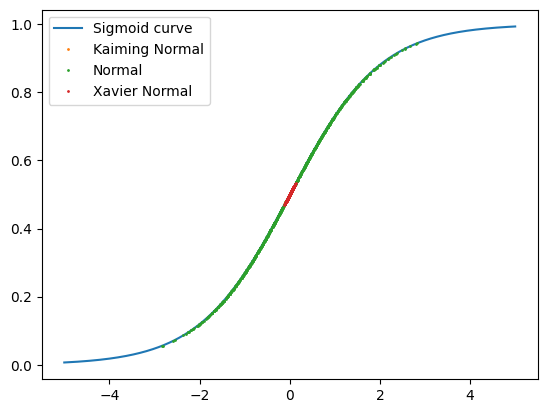

In [15]:
# We now take a closer look to the sigmoid activation function.
# Where does the sigmoid function create small gradients and where are the biggest gradients?

# Explanation here
# The sigmoid function creates the smallest gradients at the extreme values (when x approaches -5 or +5), where the curve flattens out
# and becomes nearly horizontal (approaching 0 or 1). This is known as the "vanishing gradient problem." The biggest gradients occur at the center
# of the curve (around x = 0), where the sigmoid has its steepest slope. At x = 0, the gradient is approximately 0.25, which is the maximum.
# As we move away from zero in either direction, the gradients decrease exponentially, becoming very close to zero at |x| > 3.

# Now lets plot some different activation function methods
# Use matplotlib and plot the sigmoid activation function into the plot.
# Create 1000 sample points from x-values [-5.0, 5.0] and create y = Sigmoid(x) and plot the result. (The result should simply be the sigmoid curve)
# You can use the Sigmoid function from PyTorch here!

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

# Code here
x = np.linspace(-5.0, 5.0, 1000)
y = torch.sigmoid(torch.tensor(x))
plt.plot(x, y, label="Sigmoid curve")


# Now lets plot the kaiming normal weight initialization into the plot
# Create 1000 points (x) sampled from the kaiming_normal_ (pytorch function) and create y = Sigmoid(kaiming_normal(1000)) and plot the result into the same plot as before.
# Use a different color for plotting the results


# Code here
kaiming_x = torch.empty(1000).normal_(mean=0.0, std=np.sqrt(2/784))
kaiming_y = torch.sigmoid(kaiming_x)
plt.plot(kaiming_x.numpy(), kaiming_y.numpy(), 'o', ms=1, label="Kaiming Normal")


# Now plot a random normal (torch.randn) weight initialization into the plot
# Create 1000 points (x) sampled from the randn (pytorch function) and create y = Sigmoid(randn(1000)) and plot the result into the same plot as before.
# Use a different color for plotting the results


# Code here
randn_x = torch.randn(1000)
randn_y = torch.sigmoid(randn_x)
plt.plot(randn_x.numpy(), randn_y.numpy(), 'o', ms=1, label="Normal")


# Now plot a xavier_normal weight initialization into the plot
# Create 1000 points (x) sampled from the xavier_normal_ (pytorch function) and create y = Sigmoid(xavier_normal_(1000)) and plot the result into the same plot as before.
# Use a different color for plotting the results


# Code here
xavier_x = torch.empty(1000, 1)
nn.init.xavier_normal_(xavier_x)
xavier_x = xavier_x.flatten()
xavier_y = torch.sigmoid(xavier_x)
plt.plot(xavier_x.numpy(), xavier_y.numpy(), 'o', ms=1, label="Xavier Normal")


plt.legend()
plt.show()


# Which weight initialization technique is best when using sigmoid activation function?

# Answer here
# Xavier Normal initialization is the best choice for sigmoid activation functions. Looking at the plot, Xavier initialization
# concentrates most weight values in the linear region of the sigmoid (around x = 0), where gradients are largest. This helps avoid the vanishing
# gradient problem that occurs at the saturation regions (extreme values).

# Kaiming Normal initialization, designed for ReLU activations, tends to produce slightly larger values that push some activations toward the
# flatter regions of sigmoid, resulting in smaller gradients. Standard Normal (randn) produces even more extreme values, causing many neurons to
# saturate and have very small gradients.

# Xavier initialization keeps the variance of activations and gradients consistent across layers, which is optimal for sigmoid and tanh activation functions,
# leading to more stable and efficient training.



## Be creative and test some other weight initialization techniques! - There is so much to explore!